In [18]:
#Import libraries

import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
from keras.utils import Sequence
from keras.models import load_model
from tensorflow.distribute import MirroredStrategy

In [19]:
#All paths

Path = "/home/ug-ml/felix-ML/DataGenerator2/Data" #Path where training and validation data is
SaveDataPath = "/home/ug-ml/Documents/GitHub_BigFiles/SaveFolder" #Base directory of place you store information of models
CifFlolder = "/home/ug-ml/felix-ML/DataGenerator2/CifFolder"
SaveFolderName = "/ConvnetR3" #Will create a folder and put in information about the outcome / inputs
ModelName = "/ConvnetR3.hdf5"


#Many variables

#Model Variables
input_shape = (36, 128, 128)

#Hyper parameters
learning_rate = 0.0005
l2_regularizer = 0.0001
loss = 'MeanSquaredError'
optimizer = "RMSprop" #Not a variable ONLY used for a note
batch_size = 32
epochs = 100
ShuffleTrainData = True

#Call back variables
TrainingPatience = 20
CheckPointMonitor = 'val_loss'
EarlyStopMonitor = 'val_loss'

#CPU variables
CPUworkers = 16

#Limit range
LatticeRange = [6, 11]


#List the name of the variables you want to save in a file
VariableListName = ["input_shape", 
                   "learning_rate", "l2_regularizer", "loss", "optimizer", "batch_size", "epochs", "ShuffleTrainData",
                   "TrainingPatience", "CheckPointMonitor", "EarlyStopMonitor",
                   "CPUworkers",
                   "LatticeRange"]

#List the variables in the same order as VariableListName
VariableListValues = [input_shape, 
                   learning_rate, l2_regularizer, loss, optimizer, batch_size, epochs, ShuffleTrainData,
                   TrainingPatience, CheckPointMonitor, EarlyStopMonitor,
                    CPUworkers,
                      LatticeRange]




In [20]:
#Early stopping and check points

EarlyStop = EarlyStopping(monitor = EarlyStopMonitor,
                          mode = 'auto',
                          verbose = 1,
                          patience = TrainingPatience)

NewPath = SaveDataPath + SaveFolderName
Checkpoint = ModelCheckpoint(NewPath + ModelName, #Save path
                             monitor = CheckPointMonitor,
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_freq = 'epoch')


#Make folder to put model and history information
try:
    os.mkdir(NewPath)
except:
    print("Folder failed to be created, it may already exist")
    
File1  = open(NewPath +"/Parameters.txt", "w+")
if(len(VariableListName) == len(VariableListValues)):
    for i in range(0, len(VariableListName)):
        File1.write(VariableListName[i] + " " + str(VariableListValues[i]) + "\n")
    File1.close()
else:
    print("VariableListName and VariableListValues do not match up, so file can not be saved")


Folder failed to be created, it may already exist


In [21]:
#Build model
strategy = MirroredStrategy() #Allows multiple GPUs

with strategy.scope():
    model = models.Sequential()
    model.add(layers.SeparableConv2D(128, (3, 3),
                                     activation='relu',
                                     data_format='channels_first',
                                     input_shape= input_shape))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.SeparableConv2D(128, (3, 3),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.SeparableConv2D(128, (3, 3),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(256, activation='relu',
                           kernel_regularizer = l2(l2_regularizer)))
    
    model.add(layers.Dense(1))

    model.compile(loss = loss,
                  optimizer = optimizers.RMSprop(learning_rate = learning_rate))

#Save summary of model
with open(NewPath + '/summary.txt','w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_9 (Separabl (None, 128, 126, 126)     5060      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 63, 63)       0         
_________________________________________________________________
separable_conv2d_10 (Separab (None, 128, 61, 61)       17664     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 30, 30)       0         
_________________________________________________________________
separable_conv2d_11 (Separab (None, 128, 28, 28)       17664     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1

In [22]:
#Load data generators

class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, file_type):
        """Here self.x is a list of paths to file_type files. self.y is a
        corresponding list of labels."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.file_type = file_type

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return arrs_from_paths(batch_x, self.file_type), np.array(batch_y)

def arrs_from_paths(paths, file_type):
    if file_type == "txt":
        return np.array([np.loadtxt(file_name) for file_name in paths])
    elif file_type == "npy":
        return np.array([np.load(file_name) for file_name in paths]) 
    
    
#Define Data gemerator
rng = np.random.default_rng()

PathOfFile = CifFlolder +"/FilePaths.txt"
with open(PathOfFile) as textFile:
    lines = [line.split() for line in textFile]


training_path = []
training_labels = []
validation_path = []
validation_labels = []
for i in lines:
    PathSplit = i[0].split("/")
    for j in PathSplit:
        if(j == "training"):
            if(float(i[3]) > LatticeRange[0] and float(i[3]) < LatticeRange[1]):
                training_path.append(i[0])
                training_labels.append(int(i[2]) / 9)
                break
            
        elif(j == "validation"):
            if(float(i[3]) > LatticeRange[0] and float(i[3]) < LatticeRange[1]):
                validation_path.append(i[0])
                validation_labels.append(int(i[2]) / 9)
                break

                
trainsize = len(training_path)
validationsize = len(validation_path)

ShuffleTraining = np.arange(trainsize, dtype = np.int)
ShuffleValidation = np.arange(validationsize, dtype = np.int)

training_path_shuffled = training_path.copy()
training_labels_shuffled = training_labels.copy()
validation_path_shuffled = validation_path.copy()
validation_labels_shuffled = validation_labels.copy()

rng.shuffle(ShuffleTraining)
rng.shuffle(ShuffleValidation)

for i in range(0, trainsize):
    training_path_shuffled[i] = training_path[ShuffleTraining[i]]
    training_labels_shuffled[i] = training_labels[ShuffleTraining[i]]
    #print(training_path_shuffled[i], training_labels_shuffled[i])

for i in range(0, validationsize):
    validation_path_shuffled[i] = validation_path[ShuffleValidation[i]]
    validation_labels_shuffled[i] = validation_labels[ShuffleValidation[i]]
    #print(validation_path_shuffled[i], validation_labels_shuffled[i])







print("data done.")
training_seq = FelixSequence(training_path_shuffled, training_labels_shuffled, batch_size, "npy")
print("training_seq done.")
val_images = arrs_from_paths(validation_path_shuffled, "npy")
print("val_images done.")
val_lab = np.array(validation_labels_shuffled.copy())
print("val_lab done.")
print("Complete")

data done.
training_seq done.
val_images done.
val_lab done.
Complete


In [23]:
#print(training_labels_shuffled)

In [24]:


#Run model
history = model.fit(training_seq, 
                    epochs=epochs, 
                    validation_data = (val_images, val_lab), 
                    callbacks=[EarlyStop, Checkpoint], 
                    workers = CPUworkers,
                    shuffle = ShuffleTrainData,
                    use_multiprocessing = False)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
370/370 [==============================] - ETA: 0s - loss: 0.0776
Epoch 00001: val_loss improved from inf to 129.89903, saving model to /home/ug-ml/Documents/GitHub_BigFiles/SaveFolder/ConvnetR2/ConvnetR2.hdf5
370/370 [==============================] - 90s 242ms/step - loss: 0.0776 - val_loss: 129.8990
Epoch 2/100
370/370 [==============================] - ETA: 0s - loss: 0.0350
Epoch 00002: val_loss improved from 129.89903 to 38.47725, saving model to /home/ug-ml/Documents/GitHub_BigFiles/SaveFolder/ConvnetR2/ConvnetR2.hdf5
370/370 [==============================] - 79s 212ms/step - loss: 0.0350 - val_loss: 38.4772
Epoch 3/100
370/370 [==============================] - ETA: 0s - loss: 0.0256
Epoch 00003: val_loss improved from 38.47725 to 1.05135, saving model to /home/ug-ml/Documents/GitHub_BigFiles/Sav

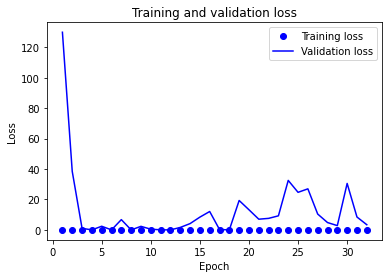

In [25]:
#Save history
with open(NewPath + '/TrainHistoryDict.dict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)


#Plot 2
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()